# Installation : 

To install the environment to run these notebooks and train a 3D segmentation model based on StarDist3D algorithm, follow this procedure :

- create a conda environment **with python 3.7** and activate it (conda create -n myenv python=3.7)
- pip install --upgrade pip
- pip install tensorflow
- conda install -c conda-forge tensorflow 
- conda install -c anaconda numpy 
- conda install -c conda-forge matplotlib 
- conda install -c conda-forge tifffile 
- conda install -c conda-forge tqdm 
- conda install jupyter  
- pip install stardist
- pip install git+https://github.com/stardist/augmend.


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os

from shutil import copyfile, rmtree
from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()


# Data :

This notebook demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polyhedra. 

For the training, the images do not need to always have the same size. StarDist will adjust automatically the size of the images during the training (by cropping them accordingly). However, the images should be big enough to contain at least several objects. For more details, read [these recommandations](https://forum.image.sc/t/neubias-academy-home-webinar-introduction-to-nuclei-segmentation-with-stardist-questions-answers/38274#labelingannotation). 

The data are loaded here for the 3D embryo example. After defining the folder where the annotated are saved, the program is going through the data and selecting all the raw images and the associated mask. The repository architecture is always the same. In each subfolder, three files are found :
- the raw image (cropped from the original stack). The z spacing was set to 500nm (instead of 250nm for the original stack - one image was removed every two images).
- the manually annotated mask, created using LabKit
- the labkit file, if some corrections are needed

In [2]:
data_dir = '/home/jb/Desktop/Data_pancreas/Annotated_data'
os.chdir(data_dir)

The first thing that needs to be defined is the training and validation/test sets. As a rule of thumbs, the validation set should represent ~15-20% of the total amount of available data. Both needs to contain images that are representative of the type of sample we want to segment. 
In our case, the selection was performed manually. From the 12 stacks available :
- 3 are going to be used as validation/test - they are all from the same data set (example 1)
- 9 for the training (example 2/3/4)

In [30]:
# Create the folders where the training and validation data will be saved
# -----------------------------------------------------------------------

if os.path.exists('data_pancreas/')==1:
    rmtree('data_pancreas/')
    
os.mkdir('data_pancreas/')
os.mkdir('data_pancreas/train')
os.mkdir('data_pancreas/train/raw') 
os.mkdir('data_pancreas/train/label') 
os.mkdir('data_pancreas/test')
os.mkdir('data_pancreas/test/raw') 
os.mkdir('data_pancreas/test/label') 

# Look for the raw data and copy the files to the appropriate folders
# -------------------------------------------------------------------

raw_list = glob('JB/example_*_ROI3.tif') + glob('Marie/example_*_ROI1.tif') + glob('Olivier/example_*_ROI2.tif')
label_list = glob('JB/example_*_ROI3_label.tif') + glob('Marie/example_*_ROI1_label.tif') + glob('Olivier/example_*_ROI2_label.tif')

raw_list = sorted(raw_list)
label_list = sorted(label_list)

print(raw_list)
print(label_list)

for n in range(len(raw_list)):
    
    src_raw = raw_list[n]
    src_label = label_list[n]

    if 'example_1' in src_raw:
        
        dst_raw = 'data_pancreas/test/raw/' + str(n) + '_raw.tif'
        copyfile(src_raw, dst_raw) 
    
        dst_label = 'data_pancreas/test/label/' + str(n) + '_label.tif'
        copyfile(src_label, dst_label) 
    else:
    
        dst_raw = 'data_pancreas/train/raw/' + str(n) + '_raw.tif'
        copyfile(src_raw, dst_raw) 
        
        dst_label = 'data_pancreas/train/label/' + str(n) + '_label.tif'
        copyfile(src_label, dst_label) 

print('A total of ' + str(n+1) + ' manually annotated images was found')


['JB/example_1_ROI3.tif', 'JB/example_2_ROI3.tif', 'JB/example_3_ROI3.tif', 'JB/example_4_ROI3.tif', 'Marie/example_1_ROI1.tif', 'Marie/example_2_ROI1.tif', 'Marie/example_3_ROI1.tif', 'Marie/example_4_ROI1.tif', 'Olivier/example_1_ROI2.tif', 'Olivier/example_2_ROI2.tif', 'Olivier/example_3_ROI2.tif', 'Olivier/example_4_ROI2.tif']
['JB/example_1_ROI3_label.tif', 'JB/example_2_ROI3_label.tif', 'JB/example_3_ROI3_label.tif', 'JB/example_4_ROI3_label.tif', 'Marie/example_1_ROI1_label.tif', 'Marie/example_2_ROI1_label.tif', 'Marie/example_3_ROI1_label.tif', 'Marie/example_4_ROI1_label.tif', 'Olivier/example_1_ROI2_label.tif', 'Olivier/example_2_ROI2_label.tif', 'Olivier/example_3_ROI2_label.tif', 'Olivier/example_4_ROI2_label.tif']
A total of 12 manually annotated images was found


Below, the training data are loaded as X and Y for the raw and the labelled images respectively. 

In [31]:
X = glob('data_pancreas/train/raw/*.tif')
Y = glob('data_pancreas/train/label/*.tif')

X = sorted(X)
Y = sorted(Y)

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]

StarDist is using information regarding the shape of the objects for the segmentation. Using the labelled images, the program is calculating the average anisotropy of the nuclei for our sample. This information will be used later to check that the network parameters (in particular the size of its **perception field**) are consistent with the size of the objects we want to segment.

NB: the output is returning a tuple related to the following dimension (Z,X,Y). In our case, the nuclei are in average isotropic in X,Y but strongly anisotropic along the Z axis. Two reasons for this: 
- the X,Y pixel size is 100nm but the z step is 500nm, hence explaining why the nuclei are appearing squished along the z direction
- the fact the images were acquired in epi-fluorescence conditions make it complicated to estimate where the nuclei are starting and ending. 

In [32]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (12.0, 1.0, 1.0746268656716418)


# Example image

In [37]:
i = 8
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)
print(img.shape)

(40, 350, 350)


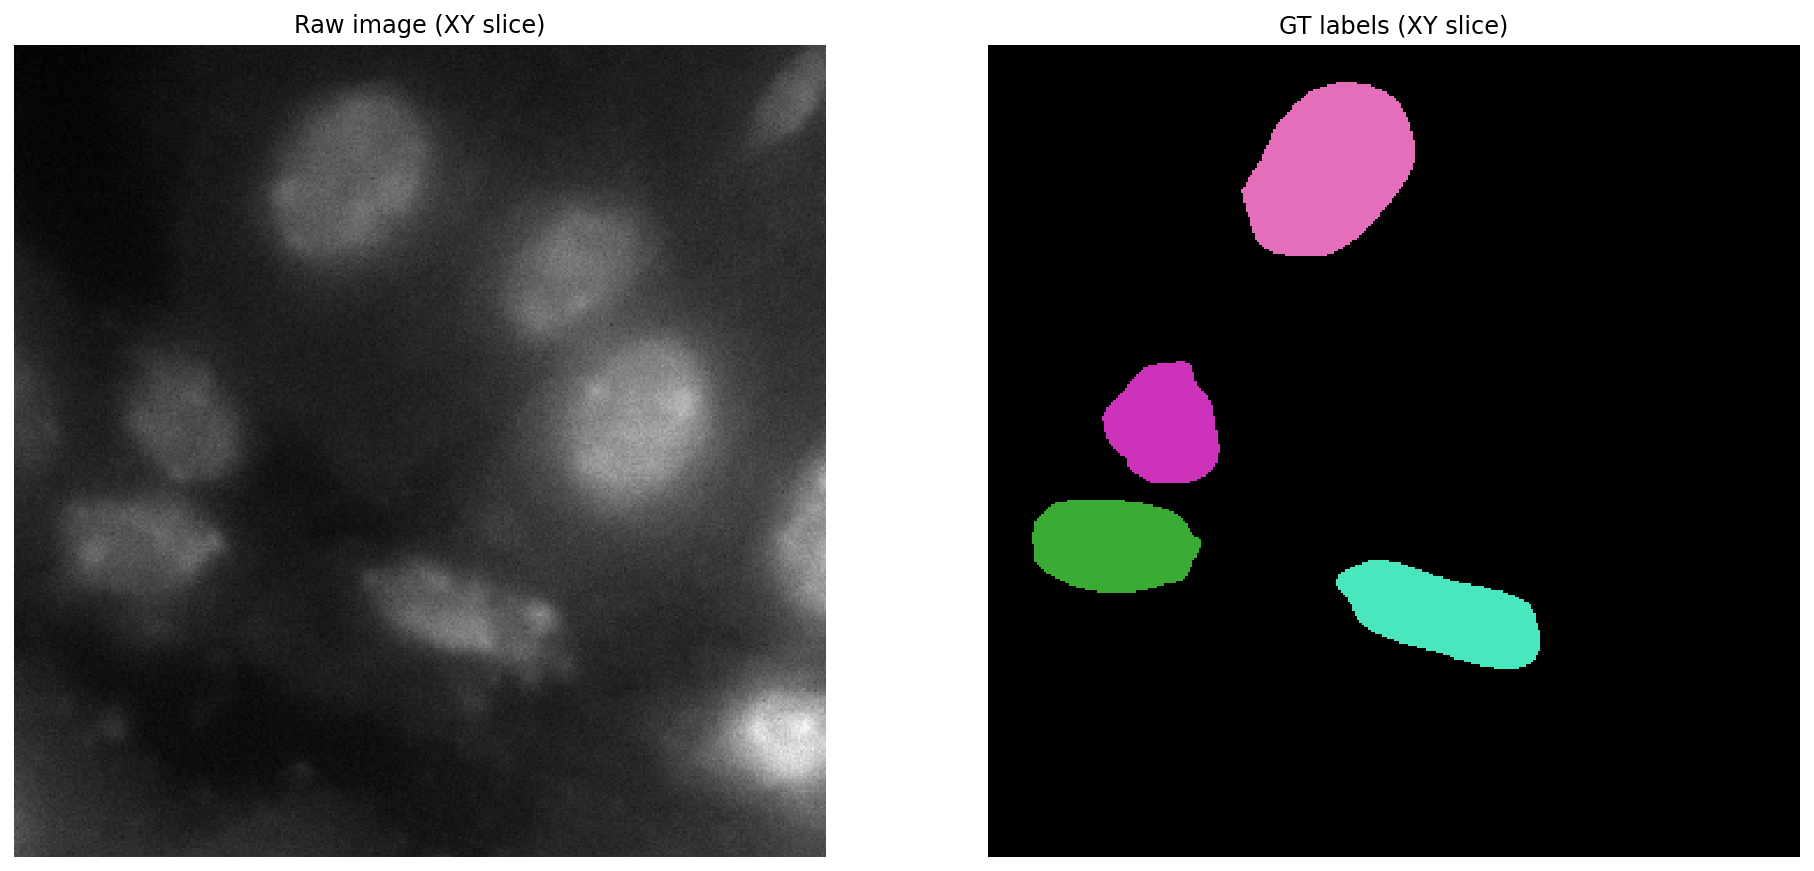

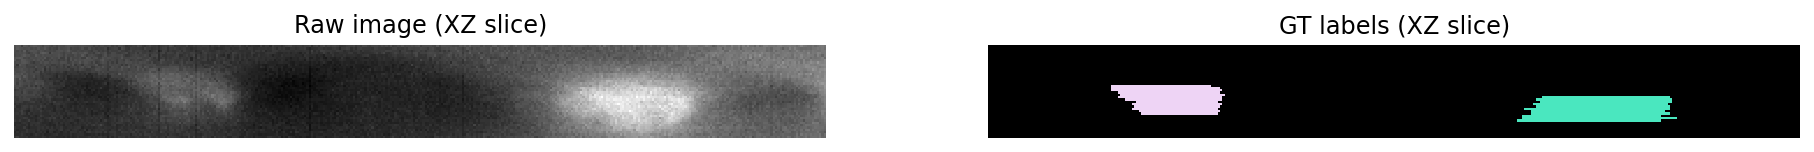

In [38]:
plt.figure(figsize=(16,10))
z = img.shape[0] // 2
y = img.shape[1] // 2
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[:,y],cmap='gray');   plt.axis('off'); plt.title('Raw image (XZ slice)')
plt.subplot(122); plt.imshow(lbl[:,y],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XZ slice)')
None;

# Fitting ground-truth labels with star-convex polyhedra

StarDist can work in two different modes :
- either assuming that the objects to segment are **Isotropic**
- or **anisotropic**.

In most of the case, the performances are better when assuming anisotropic properties for the objects. In StarDist the objects are reconstructed using a pre-defined number of rays. Below, based on the manually annotated images, the program is calculating **how accurately the nuclei can be described as a function of the number of rays**. In total, 6 values are tested, going from 8 rays to 128.

As expected, in the isotropic conditions, even with a large number of rays the performance are always below 70%. For the anisotropic conditions however, 96 rays are enough to accurately describe ~90% of the nuclei shape. There is still a slight improvement when using 128 rays but it will be at the expense of increasing the computing cost of the network. 

Since the reconstruction score is estimated here on the manually annotated data, it is also **defining the upper limit of the score of our network**. We cannot expect the trained network to return a reconstruction score higher than 90%.

In [39]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [40]:
n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|██████████| 6/6 [00:33<00:00,  5.55s/it]


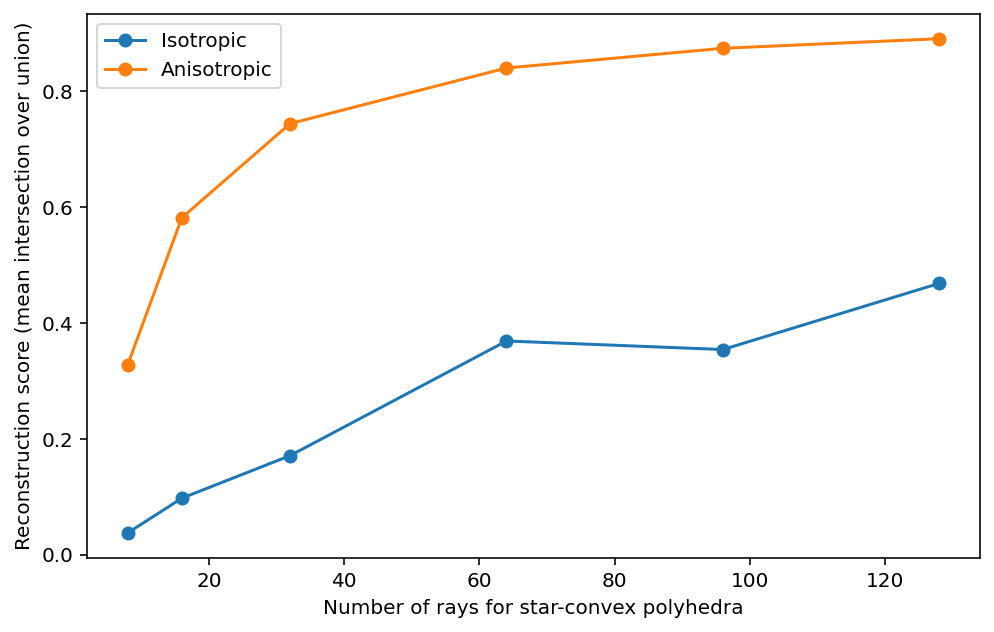

In [41]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

# Example image reconstructed with various number of rays

## Without taking anisotropy into account

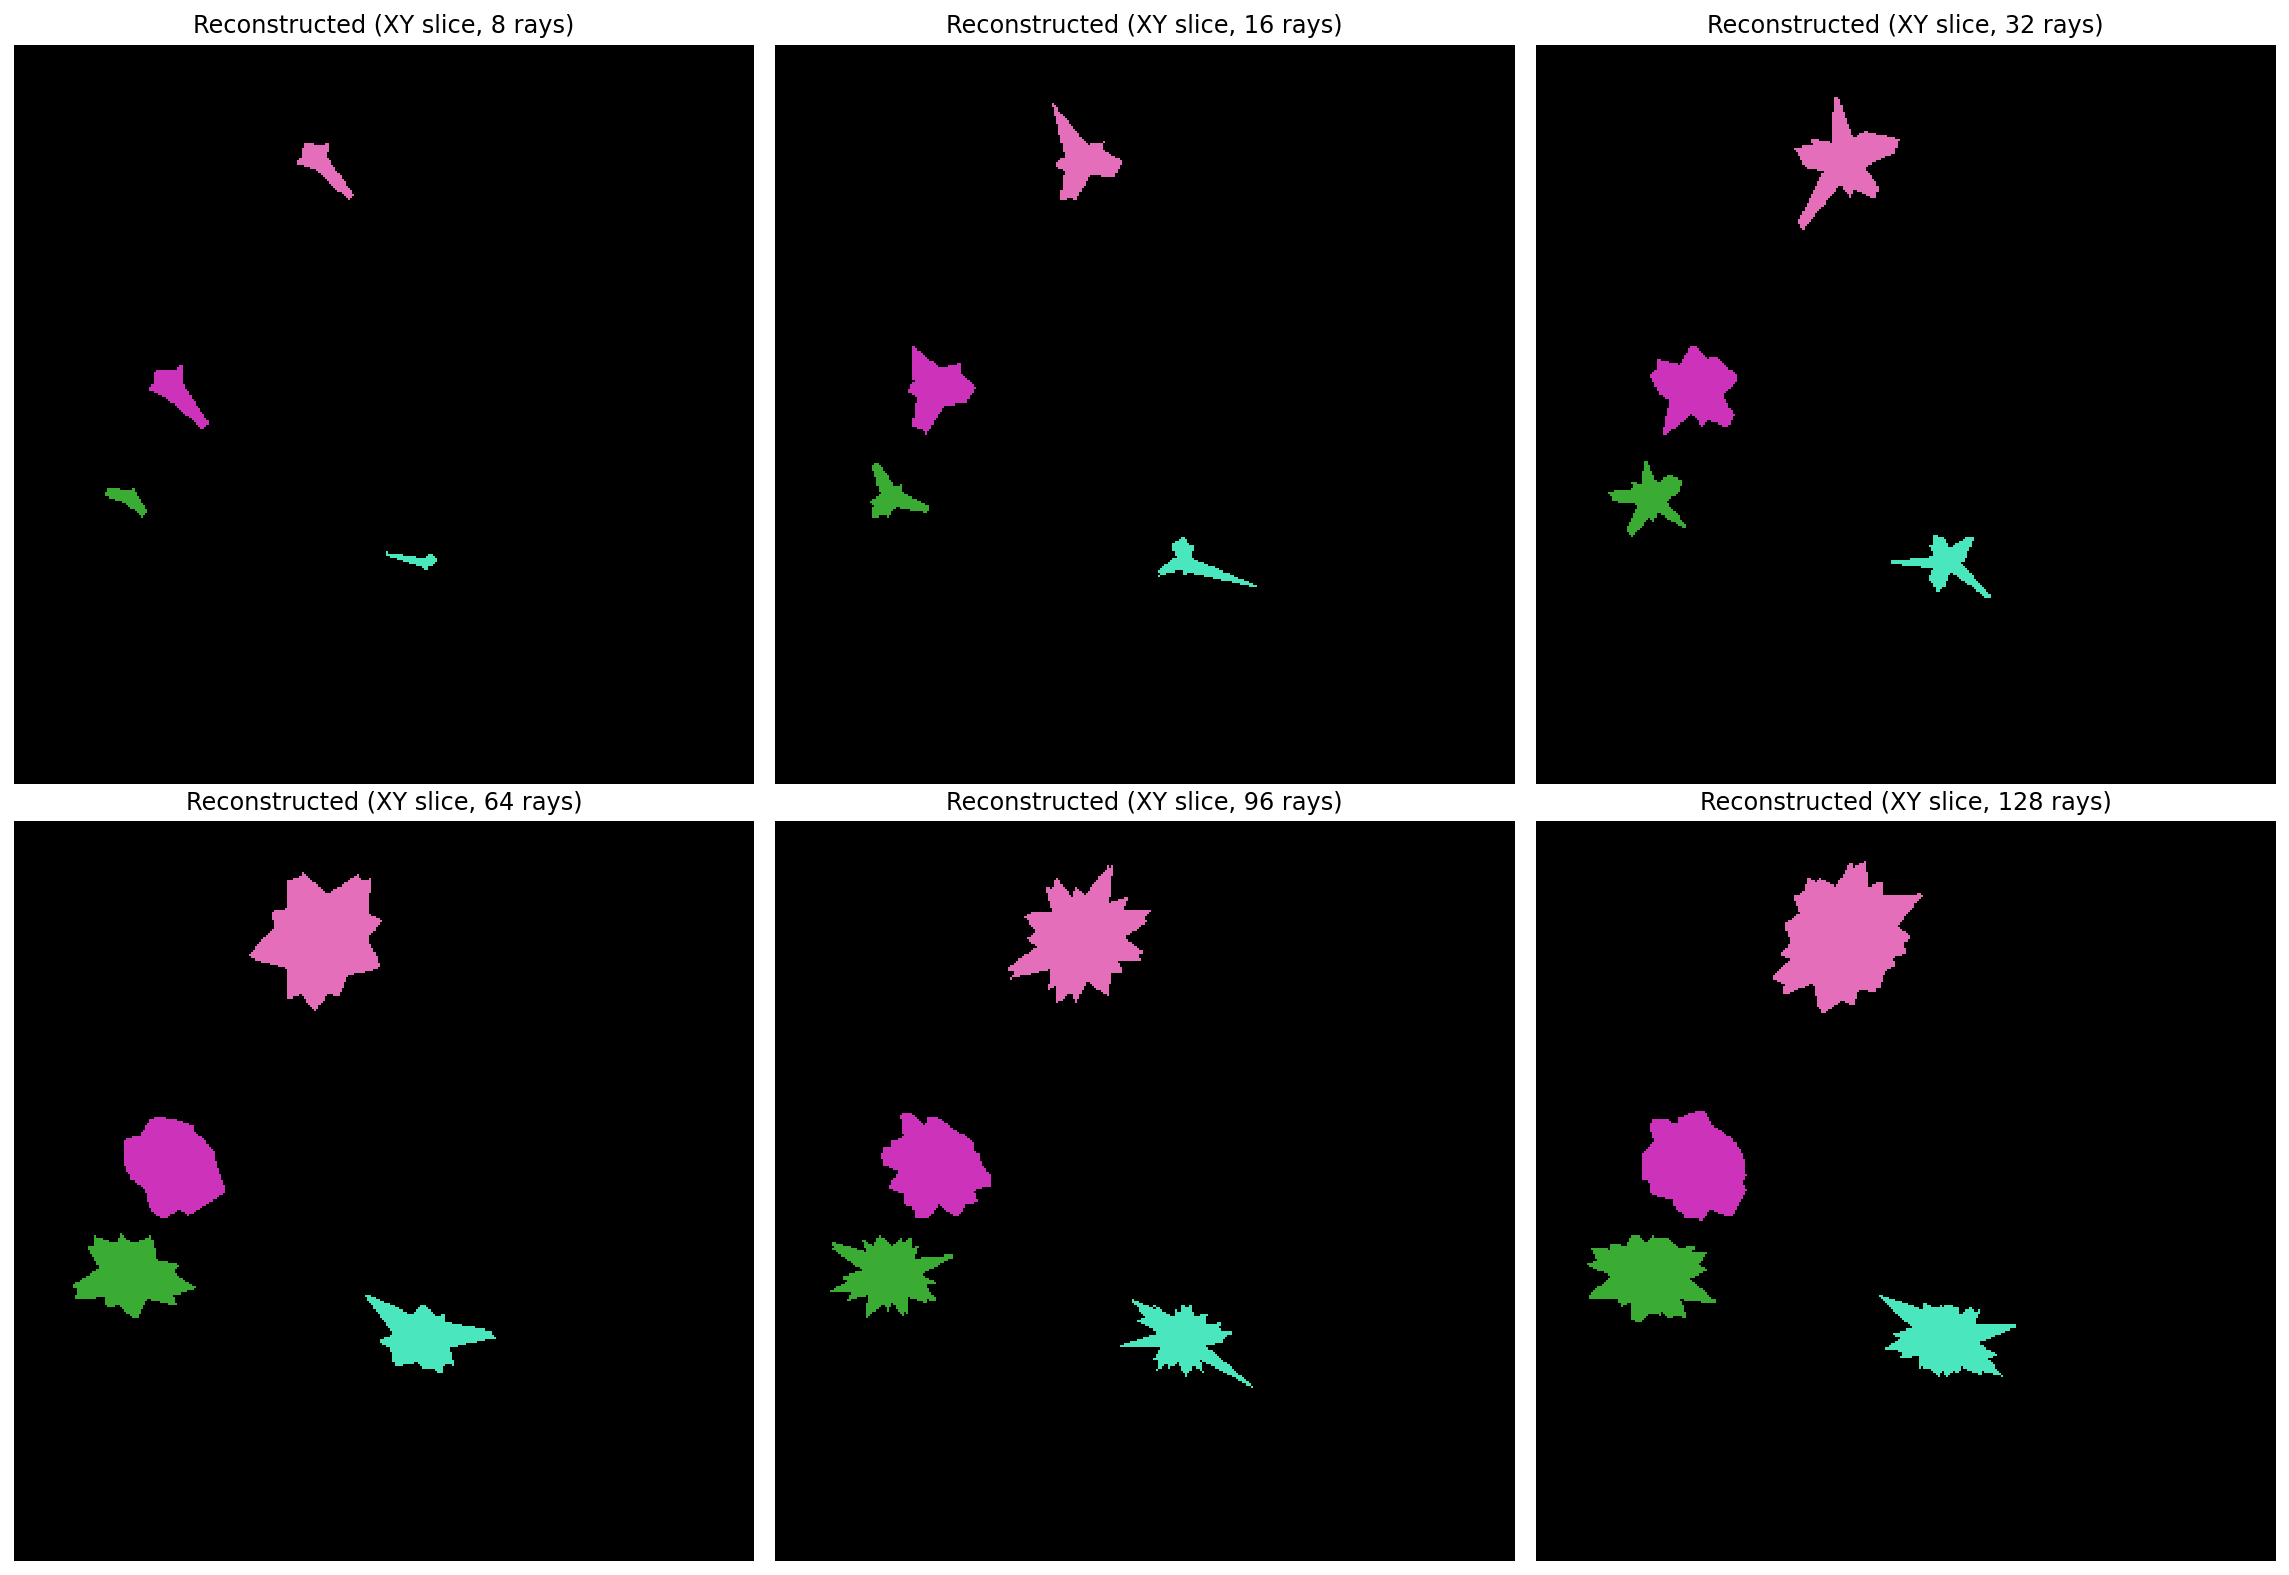

In [42]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=None)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

## Taking anisotropy into account

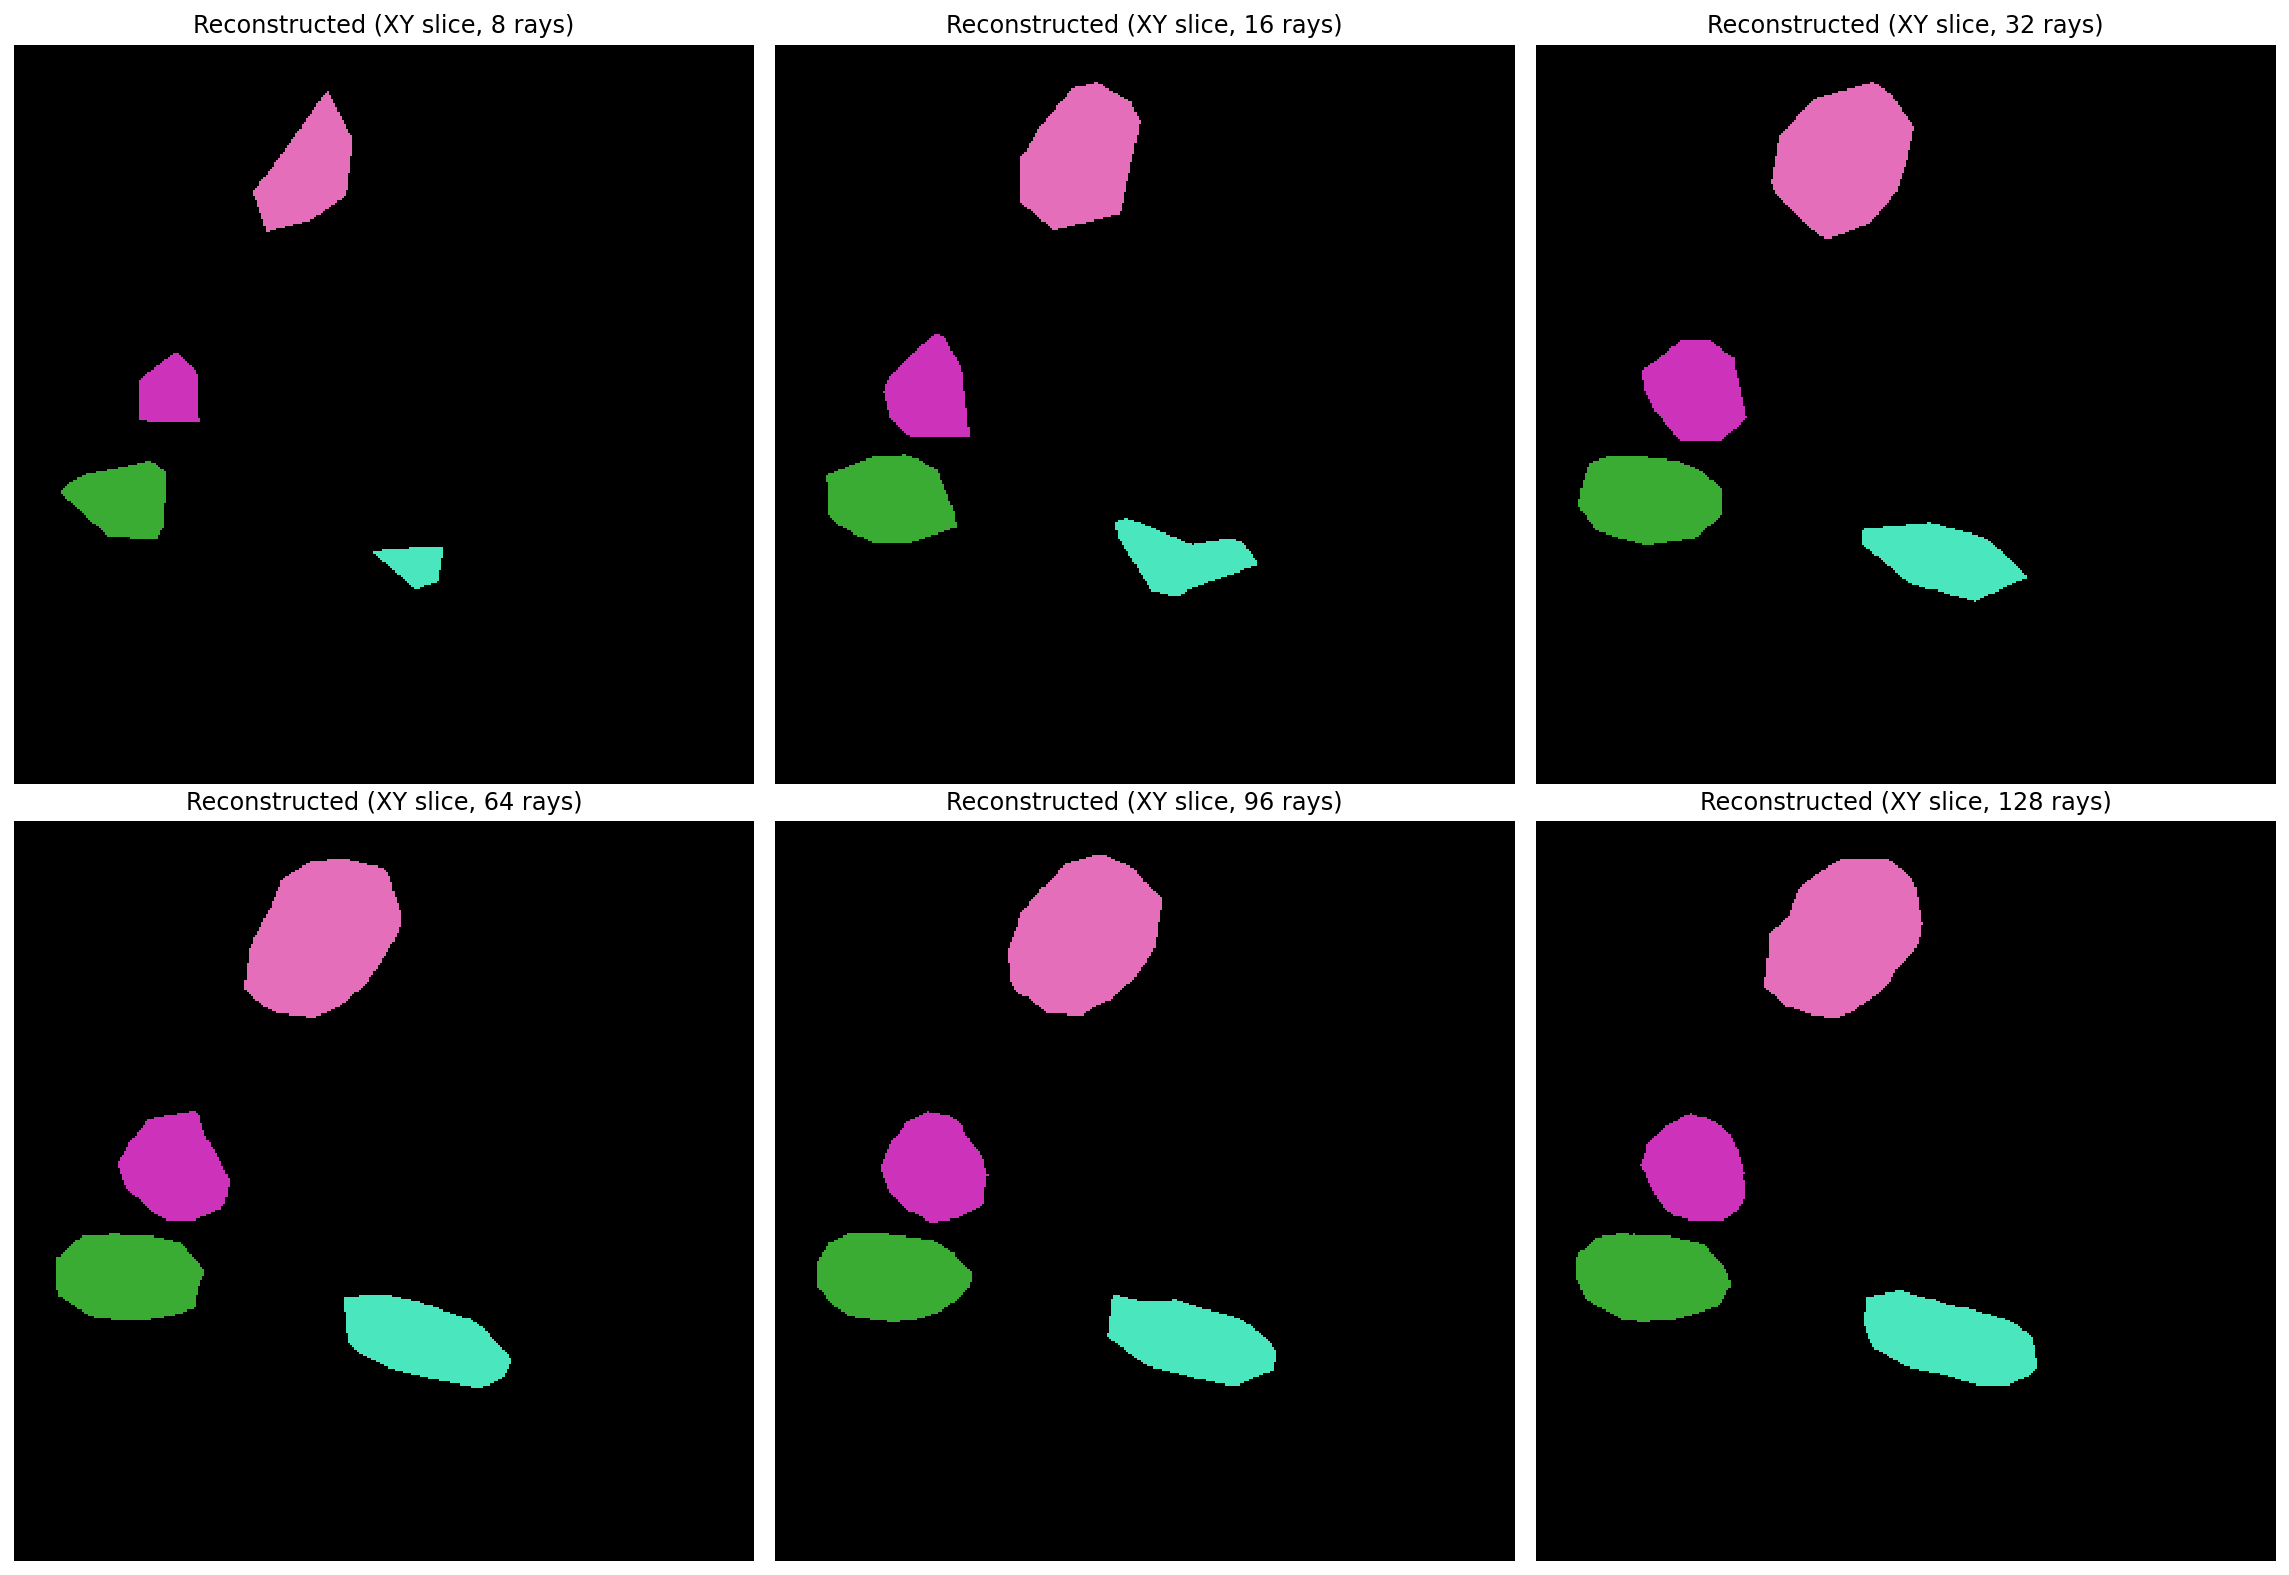

In [43]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();